In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

hr_df = pd.read_csv('../data/processed/hr_catalog.csv').set_index('hr').round(4)
constellations_df = pd.read_csv('../data/processed/constellations.csv')
hr_df

,name,ra_degrees,dec_degrees,Vmag
hr,,,,
1,BD+44 4550,1.2912,45.2292,6.70
2,BD-01 4525,1.2658,-0.5031,6.29
3,PscBD-06 6357,1.3337,-5.7075,4.61
4,PegBD+12 5063,1.4250,13.3961,5.51
5,BD+57 2865,1.5667,58.4367,5.96
...,...,...,...,...
9106,CP-73 2346,1.1279,-72.8978,7.31
9107,BD+33 4828,1.2242,34.6597,6.12
9108,CP-72 2800,1.1721,-71.4369,5.59


In [193]:
constellations = {}

for i, r in constellations_df.iterrows():
    abr = r['abr']
    constellations[abr] = []
    for n, hr_star in enumerate(r.iloc[2:-1]):
        if not hr_star.is_integer():
            break
        try:
            star1_id = hr_star
            star2_hr = r.iloc[n+3]
            if star2_hr.is_integer():
                star2_id = star2_hr
                constellations[abr].append((int(star1_id), int(star2_id)))
        except:
            pass


In [226]:
def plot_constellations(constellations, hr_df, figsize=(10, 6)):
    import numpy as np
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=figsize)

    star_ids = set()
    constellation_wraps = {}

    # First, determine which constellations cross the wrap
    for abr, lines in constellations.items():
        crosses_wrap = False
        for star1_id, star2_id in lines:
            if star1_id in hr_df.index and star2_id in hr_df.index:
                ra1 = hr_df.loc[star1_id]['ra_degrees']
                ra2 = hr_df.loc[star2_id]['ra_degrees']
                if abs(ra1 - ra2) > 180:
                    crosses_wrap = True
            star_ids.add(star1_id)
            star_ids.add(star2_id)
        constellation_wraps[abr] = crosses_wrap

    # Prepare star data for scatter plot
    ras, decs, vmags, names = [], [], [], []
    for star_id in star_ids:
        if star_id in hr_df.index:
            star = hr_df.loc[star_id]
            ras.append(star['ra_degrees'])
            decs.append(star['dec_degrees'])
            vmags.append(star['Vmag'])
            names.append(star.name)

    # Plot stars and lines, handling wrap for entire constellations
    for abr, lines in constellations.items():
        wrap = constellation_wraps[abr]
        for star1_id, star2_id in lines:
            if star1_id in hr_df.index and star2_id in hr_df.index:
                star1 = hr_df.loc[star1_id]
                star2 = hr_df.loc[star2_id]
                ra1 = star1['ra_degrees']
                ra2 = star2['ra_degrees']
                dec1 = star1['dec_degrees']
                dec2 = star2['dec_degrees']

                # If this constellation crosses the wrap, shift all stars with RA < 180 by +360
                if wrap:
                    if ra1 < 180:
                        ra1 += 360
                    if ra2 < 180:
                        ra2 += 360

                ax.plot([ra1, ra2], [dec1, dec2], color='blue', lw=1, zorder=1)

    # Now plot all stars, shifting those in wrap constellations if needed
    for abr, lines in constellations.items():
        wrap = constellation_wraps[abr]
        for star_id in set([sid for line in lines for sid in line]):
            if star_id in hr_df.index:
                star = hr_df.loc[star_id]
                ra = star['ra_degrees']
                dec = star['dec_degrees']
                vmag = star['Vmag']
                name = star.name
                if wrap and ra < 180:
                    ra += 360
                size = 100 / (vmag + 2)
                ax.scatter(ra, dec, s=size, c='yellow', marker='*', edgecolors='black', linewidth=0.5, zorder=2)
        ax.text(ra, dec, abr, fontsize=8, ha='right', va='bottom', zorder=3)

    ax.set_xlabel('Right Ascension (deg)')
    ax.set_ylabel('Declination (deg)')
    ax.set_title('Constellations')
    ax.axvline(360, color='gray', linestyle='--', lw=1)

    plt.show()
    return fig


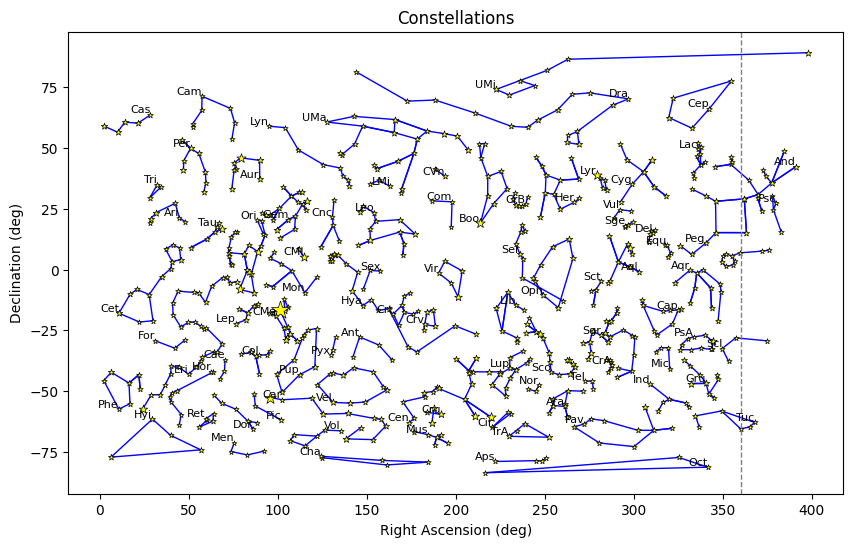

In [227]:
fig = plot_constellations(constellations, hr_df)
fig.savefig('../constellations.png', dpi=300, bbox_inches='tight')

In [220]:
import json

# 1. Find all star IDs used in constellations
star_ids = set()
for lines in constellations.values():
    for star1_id, star2_id in lines:
        star_ids.add(star1_id)
        star_ids.add(star2_id)

# 2. Determine which constellations cross the wrap
constellation_wraps = {}
for abr, lines in constellations.items():
    crosses_wrap = False
    for star1_id, star2_id in lines:
        if star1_id in hr_df.index and star2_id in hr_df.index:
            ra1 = hr_df.loc[star1_id]['ra_degrees']
            ra2 = hr_df.loc[star2_id]['ra_degrees']
            if abs(ra1 - ra2) > 180:
                crosses_wrap = True
    constellation_wraps[abr] = crosses_wrap

# 3. Build a mapping from star_id to the set of constellations it belongs to
star_constellations = {star_id: set() for star_id in star_ids}
for abr, lines in constellations.items():
    for star1_id, star2_id in lines:
        star_constellations[star1_id].add(abr)
        star_constellations[star2_id].add(abr)

# 4. Apply wrap logic and collect adjusted RAs
adjusted_ras = {}
for star_id in star_ids:
    if star_id in hr_df.index:
        star = hr_df.loc[star_id]
        ra = float(star['ra_degrees'])
        wraps = any(constellation_wraps[abr] for abr in star_constellations[star_id])
        if wraps and ra < 180:
            ra += 360
        adjusted_ras[star_id] = ra

# 5. Min/max normalization
ra_min = min(adjusted_ras.values())
ra_max = max(adjusted_ras.values())

stars = []
for star_id in star_ids:
    if star_id in hr_df.index:
        star = hr_df.loc[star_id]
        ra = adjusted_ras[star_id]
        dec = float(star['dec_degrees'])
        vmag = float(star['Vmag'])
        x = ((ra - ra_min) / (ra_max - ra_min)) * 100 if ra_max > ra_min else 50
        y = ((dec + 90) / 180) * 100
        stars.append({
            "id": int(star_id),
            "x": round(x, 4),
            "y": round(y, 4),
            "vmag": vmag
        })

data = {
    "stars": stars,
    "constellations": constellations
}

with open('../data/processed/constellations_xy.json', 'w') as f:
    json.dump(data, f, indent=4)
